In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cv2
import Comparison_v2 as CM
import os
import DataSetting_v2 as DS

In [ ]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

### Comparison

In [2]:
notion = '240523Comp1'
save_path = f'../saved/{notion}/'
figs = []

In [3]:
datadir = f'../dataset/0509/make19_30-finished/'
data = DS.ModalityLoader(data_dir=datadir, mmap_mode='r', modalities={'rimg', 'tag'})
test_gt = data.profiling({'T03', 'T04'})

Loading from ../dataset/0509/make19_30-finished/


  0%|          | 0/10 [00:00<?, ?it/s]

Profiled by {'T04', 'T03'}


30Center loading...
30Center loaded Estimates of (5069, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 432x288 with 0 Axes>

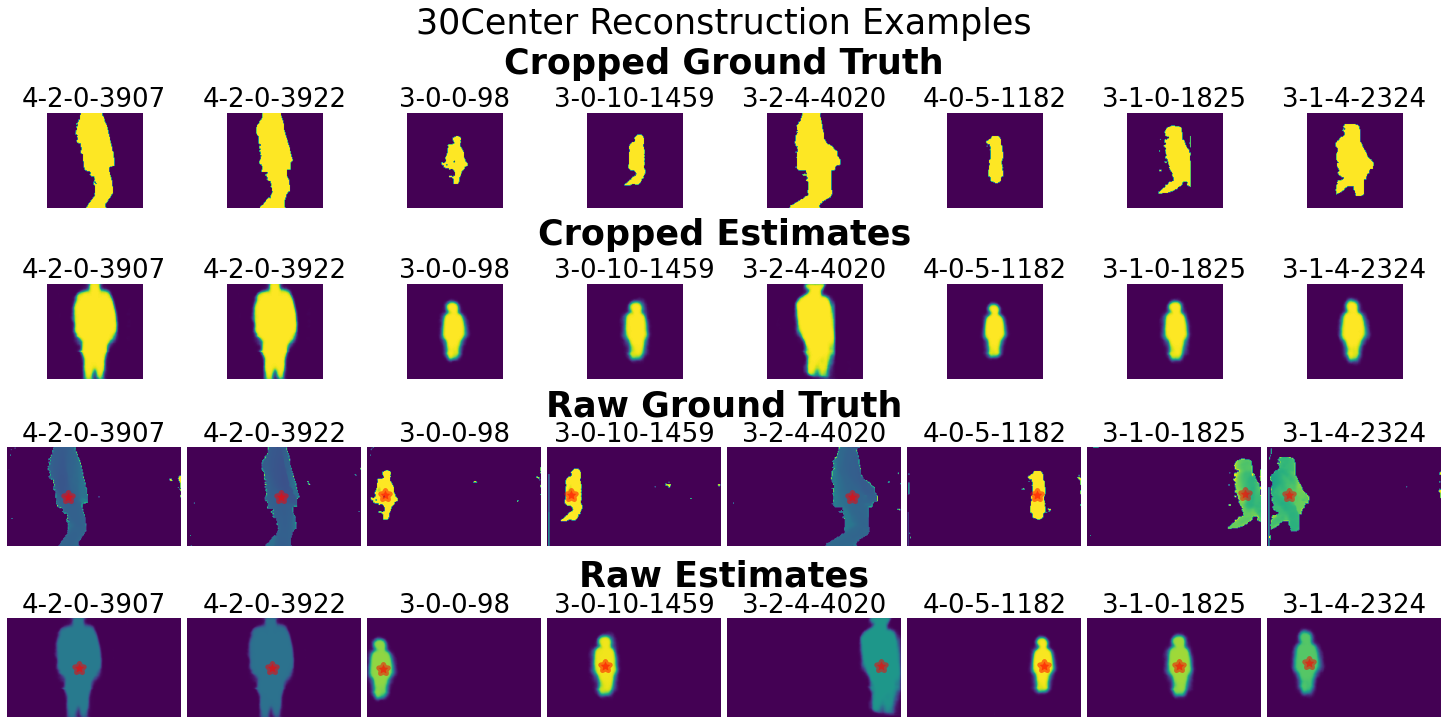

In [4]:
C30 = CM.CenterResultCalculator('30Center', '../saved/240512_30C/240512_30C_Student_pred.npy', test_gt)
C30.resize()
figs.append(C30.plot_example())

30BBX loading...
30BBX loaded Estimates of (5069, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 432x288 with 0 Axes>

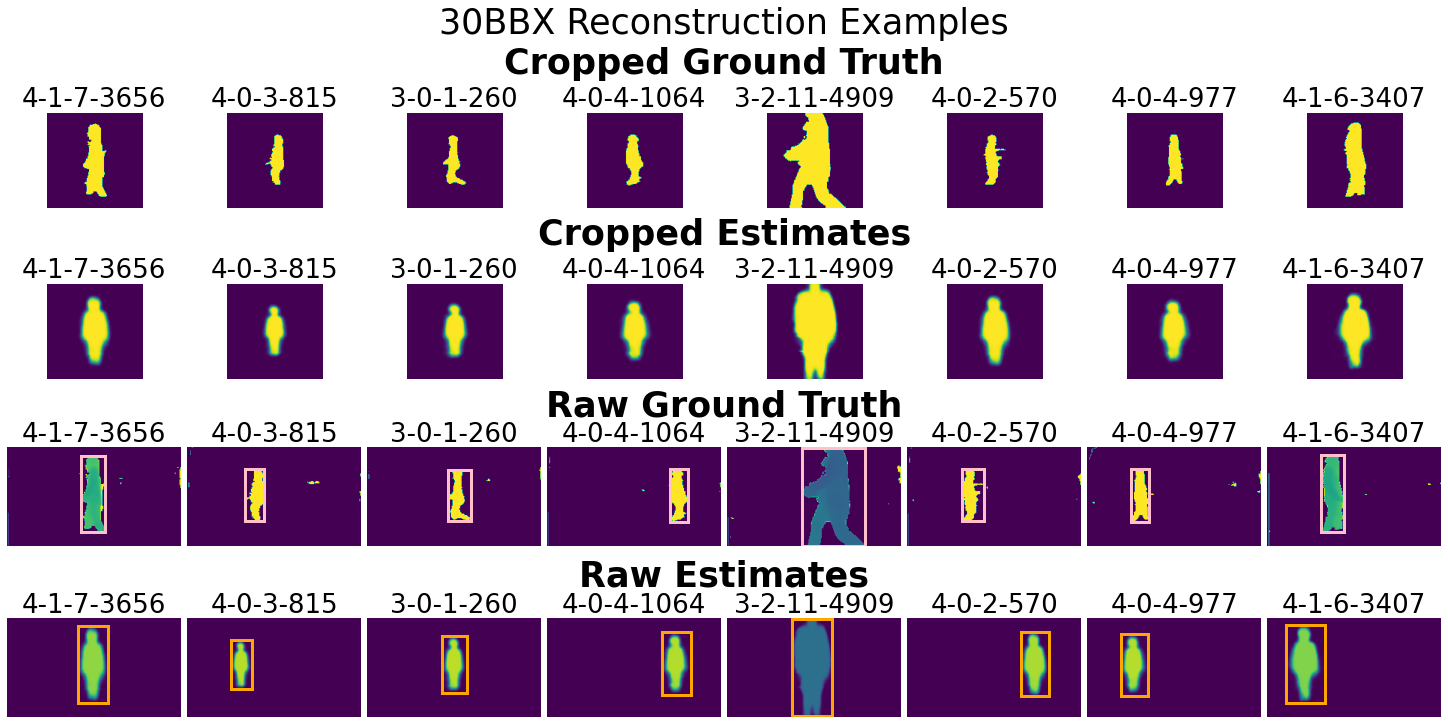

In [4]:
D30 = CM.BBXResultCalculator('30BBX', '../saved/240512_30D/240512_30_Student_pred.npy', test_gt)
D30.resize()
figs.append(D30.plot_example())

30BBX calculating 2D correlation...Done!


<Figure size 1440x720 with 0 Axes>

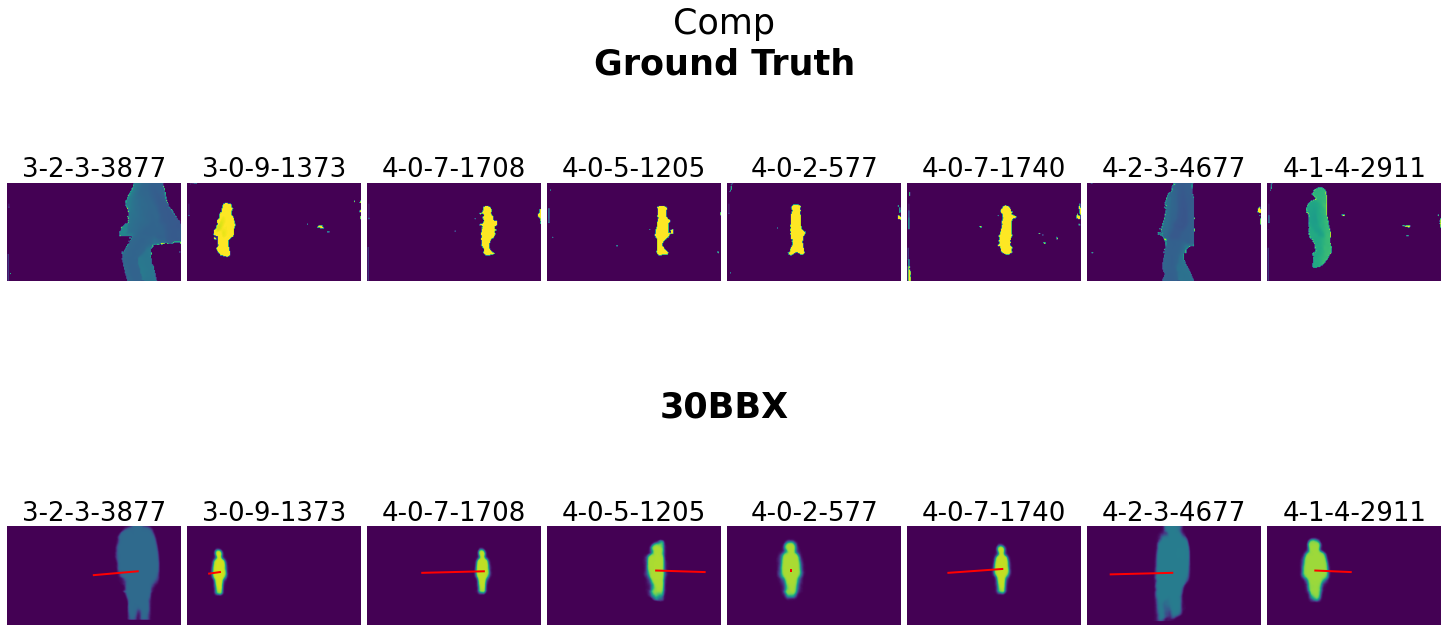

<Figure size 1440x720 with 0 Axes>

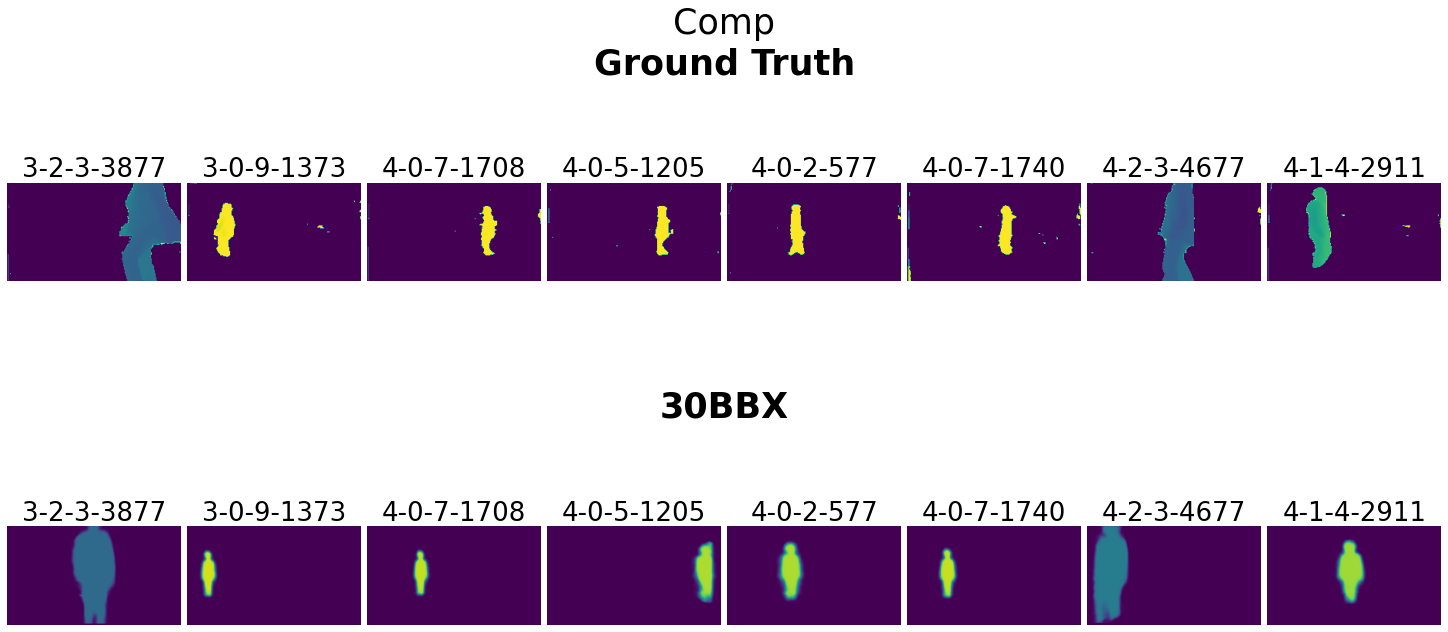

In [5]:
D30.matching_mae(scale=0.3)
fig, fname, inds = CM.visualization(D30, univ_gt=test_gt, title='Comp', matched=True)
figs.append(CM.visualization(D30, univ_gt=test_gt, inds=inds, title='Comp', matched=False))

<Figure size 1440x720 with 0 Axes>

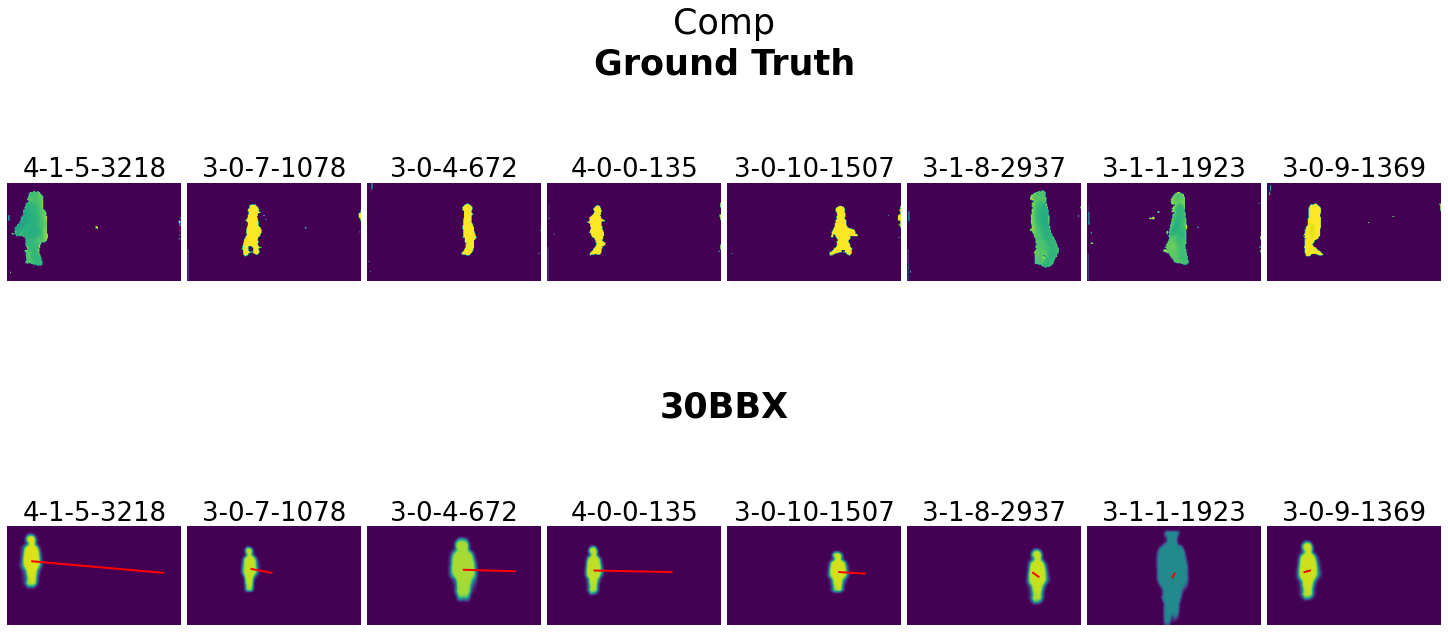

In [8]:
inds[0] = [4, 1, 5, 3218]
fig, fname, inds = CM.visualization(D30, univ_gt=test_gt, inds=inds, title='Comp', matched=True)

100Center loading...
100Center loaded Estimates of (4953, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 1440x720 with 0 Axes>

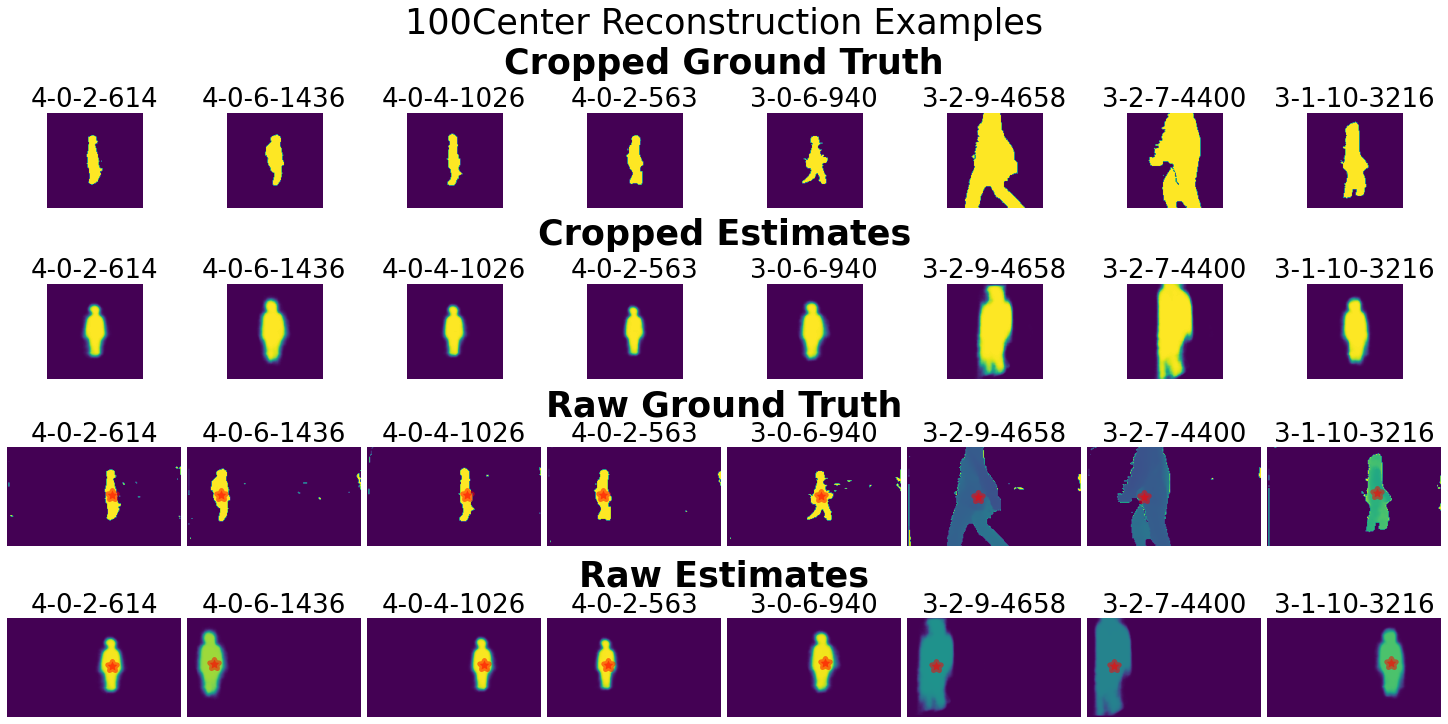

In [6]:
C100 = CM.CenterResultCalculator('100Center', '../saved/240512_100C/240512_100C_Student_pred.npy', test_gt)
C100.resize()
figs.append(C100.plot_example())

100BBX loading...
100BBX loaded Estimates of (4953, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 1440x720 with 0 Axes>

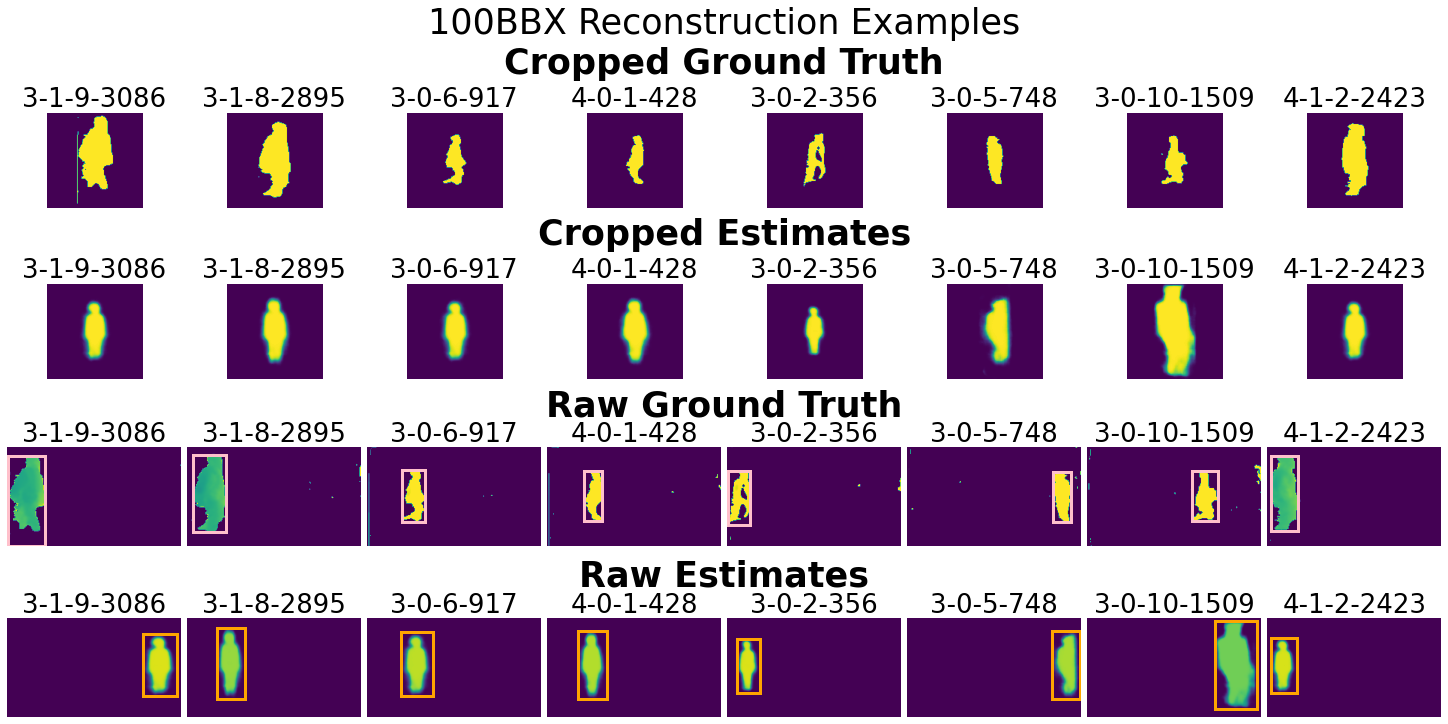

In [7]:
D100 = CM.BBXResultCalculator('100BBX', '../saved/240512_100D/240512_100D_Student_pred.npy', test_gt)
D100.resize()
figs.append(D100.plot_example())

300Center loading...
300Center loaded Estimates of (4611, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 1440x720 with 0 Axes>

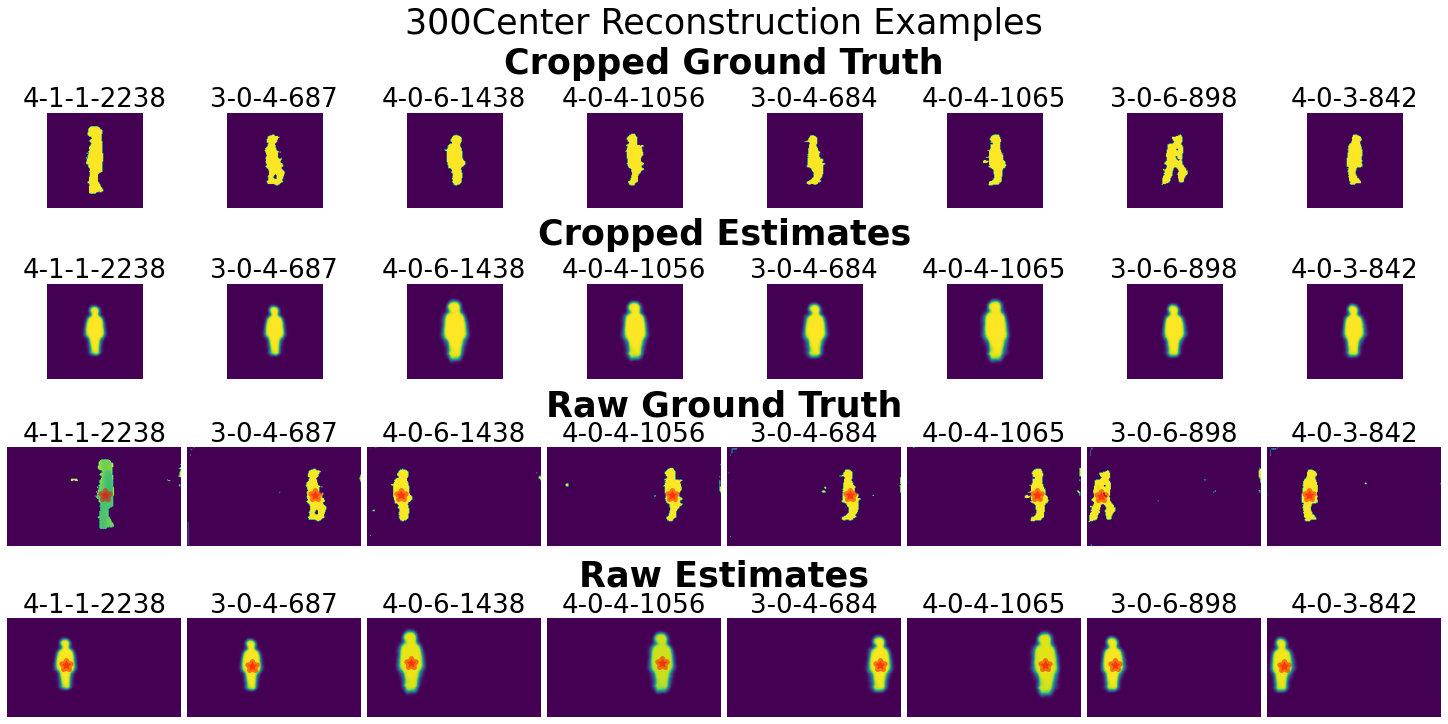

In [8]:
C300 = CM.CenterResultCalculator('300Center', '../saved/240512_300C/240512_300C_Student_pred.npy', test_gt)
C300.resize()
figs.append(C300.plot_example())

300BBX loading...
300BBX loaded Estimates of (4611, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 1440x720 with 0 Axes>

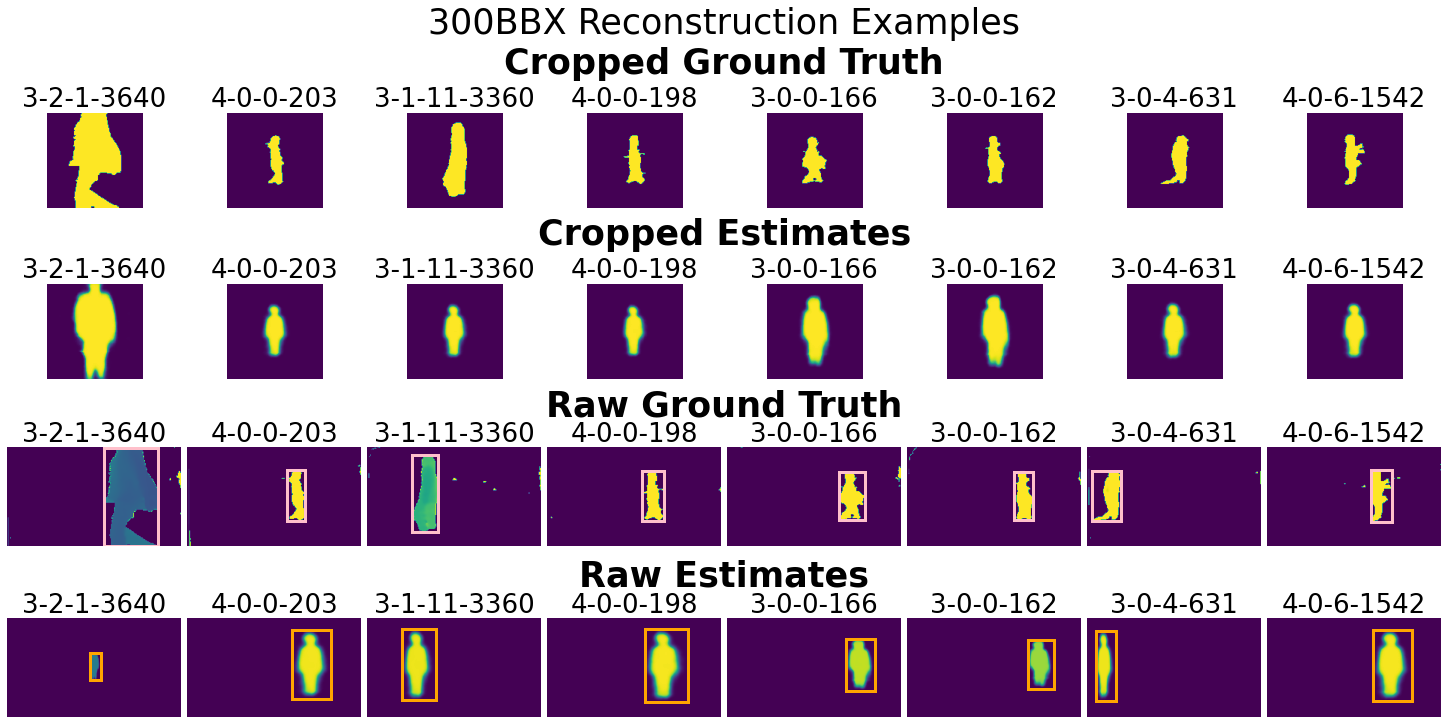

In [9]:
D300 = CM.BBXResultCalculator('300BBX', '../saved/240512_300D/240512_300D_Student_pred.npy', test_gt)
D300.resize()
figs.append(D300.plot_example())

In [10]:
Z30 = CM.ZeroEstimates('Z30Nromal', None, test_gt)

Z30Nromal loading...
Z30Nromal loaded Zero Estimates


30Center calculating loss...

/home/bob/datastore/Models/Comparison_v2.py:48: UserWarning: Using a target size (torch.Size([1, 1, 128, 226])) that is different to the input size (torch.Size([128, 226])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.result[i] = F.mse_loss(pred, torch.from_numpy(self.gt[_ind][_take]))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
30Center calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

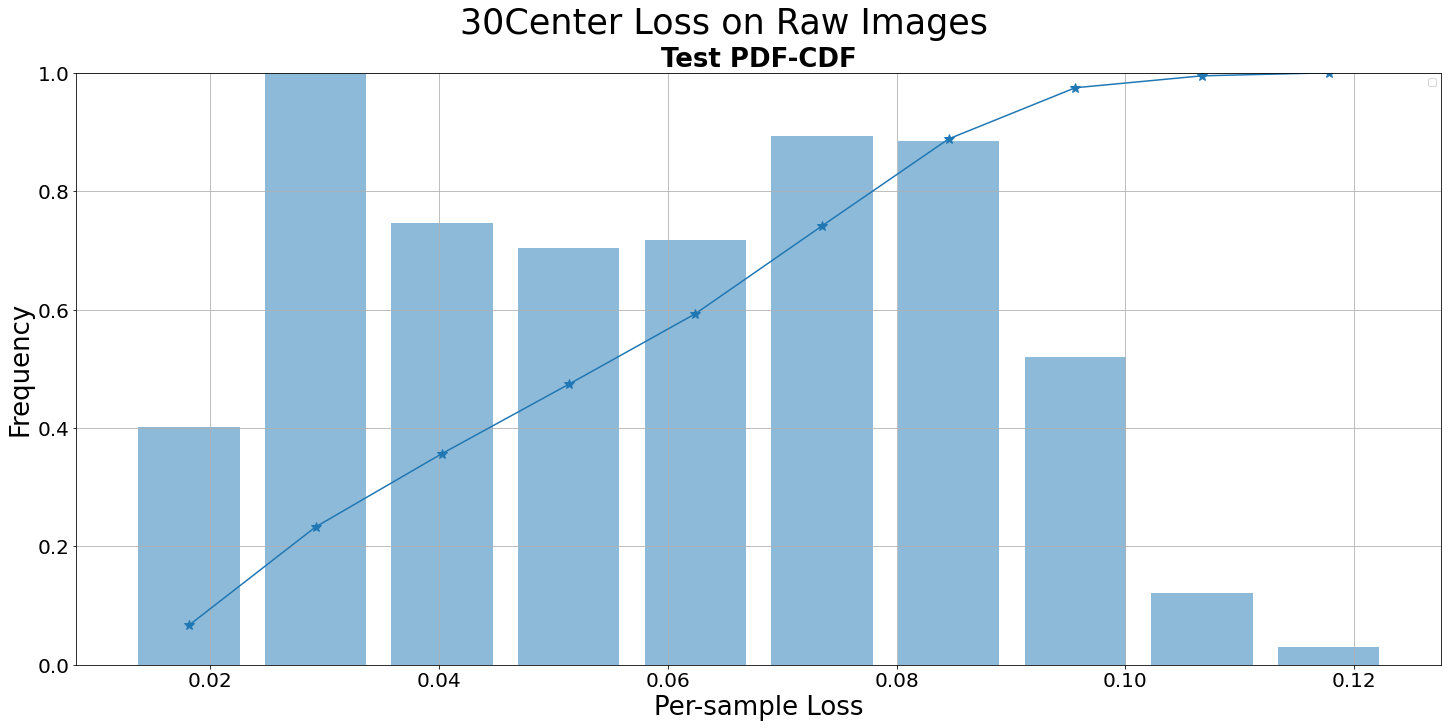

30BBX calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
30BBX calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

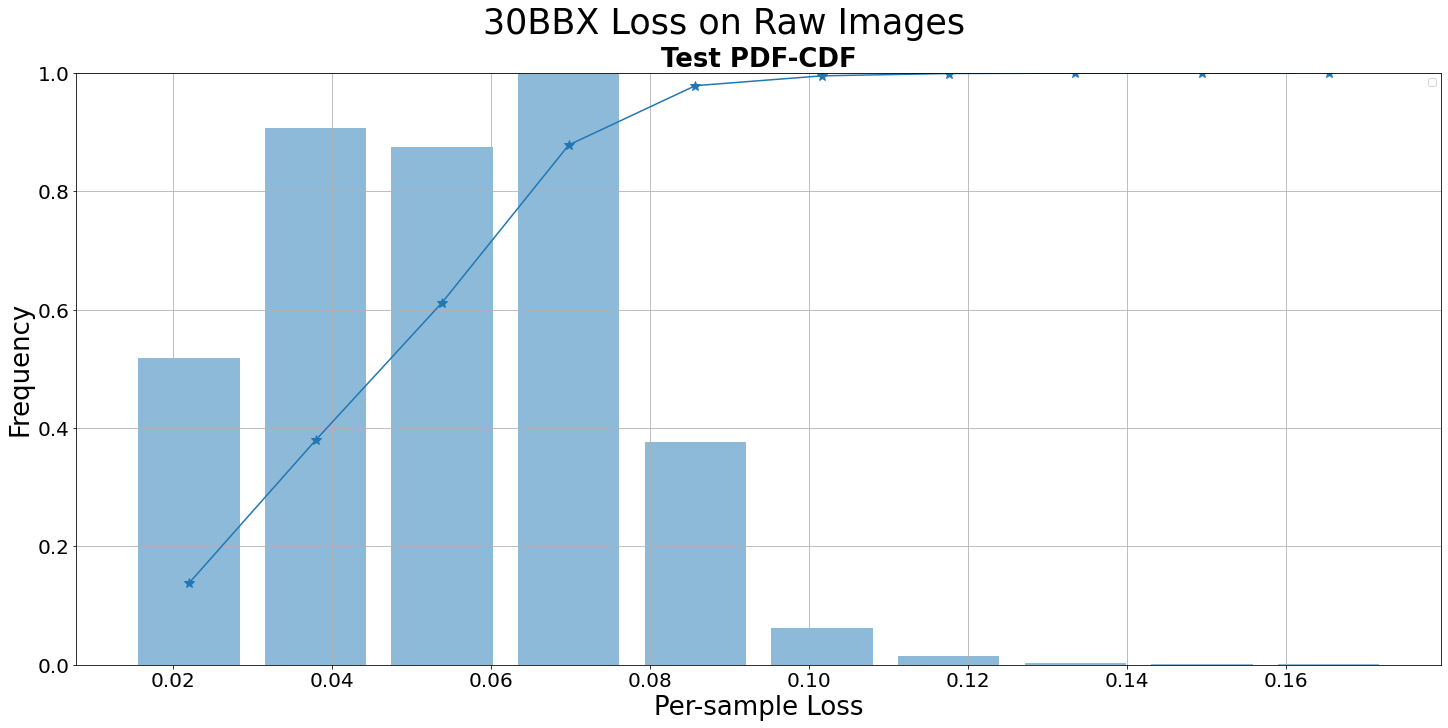

100Center calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
100Center calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

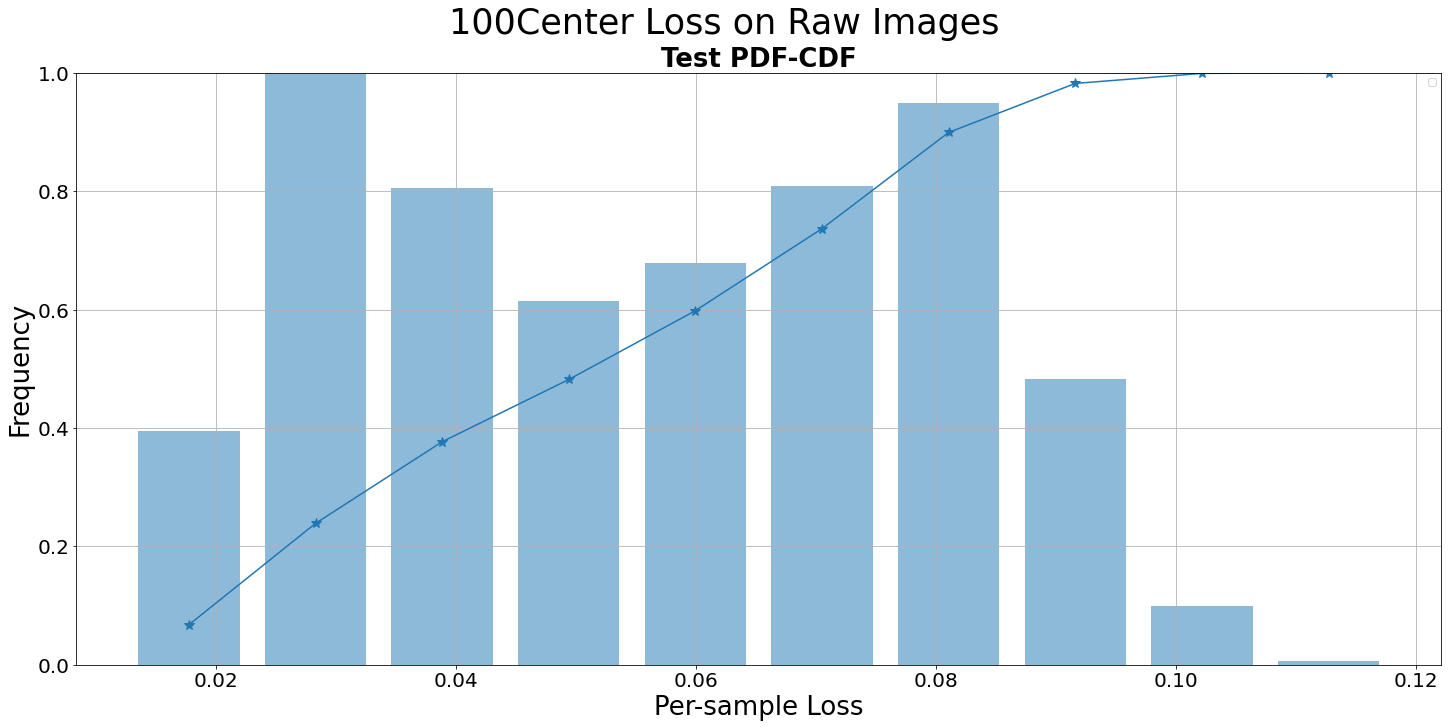

100BBX calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
100BBX calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

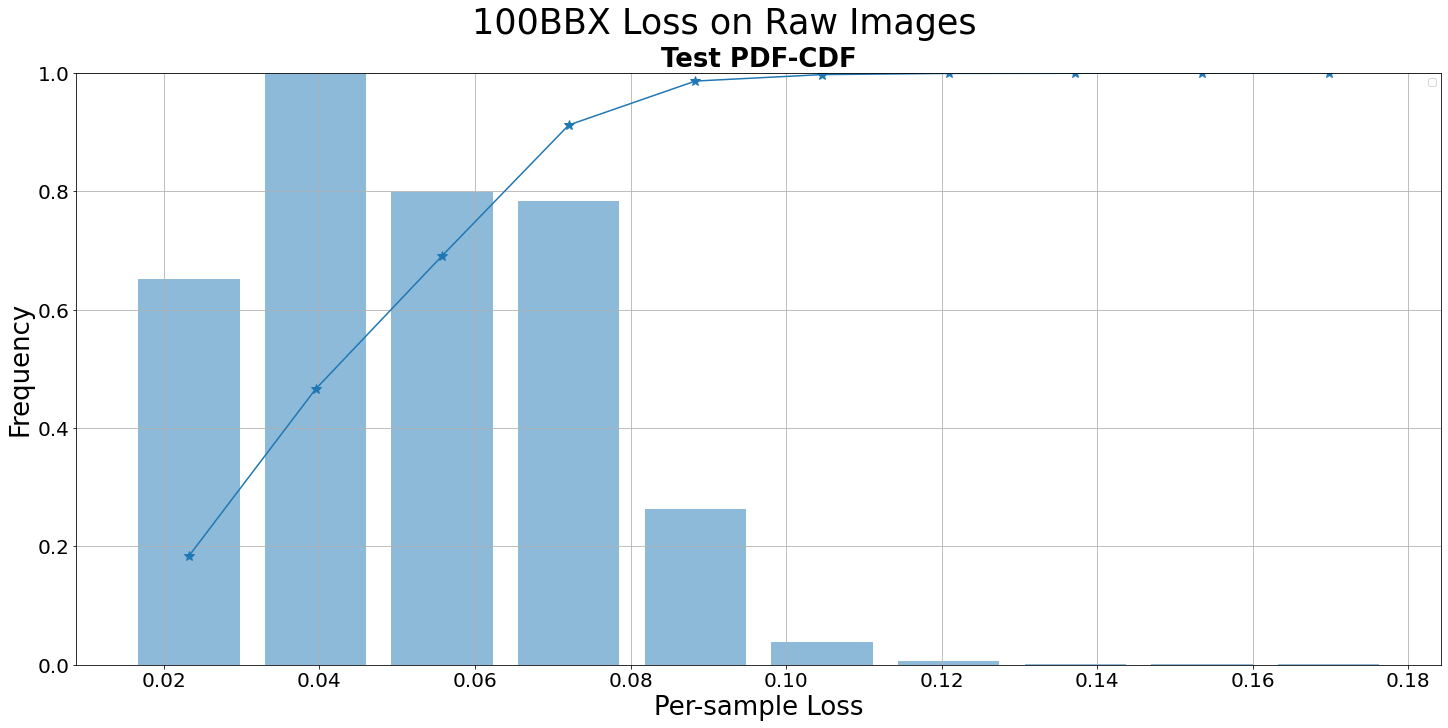

300Center calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
300Center calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

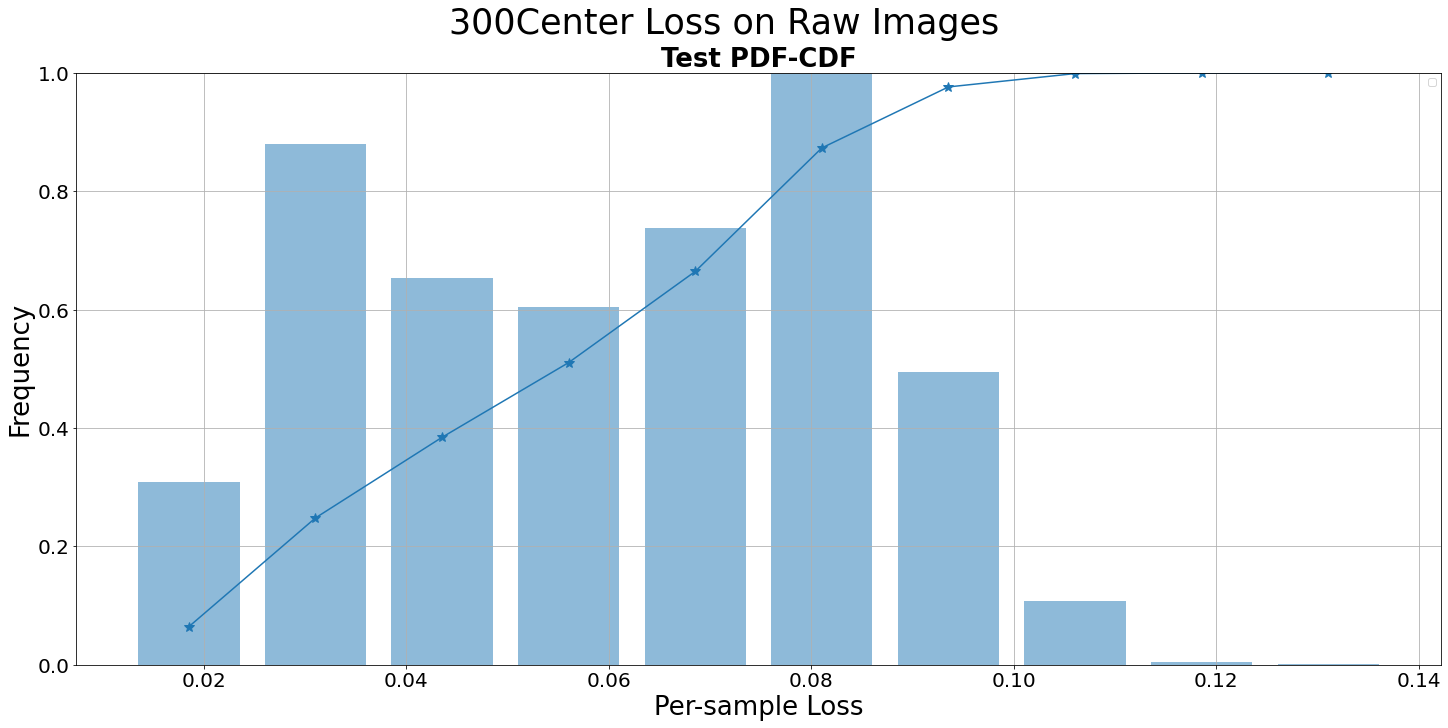

300BBX calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
300BBX calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

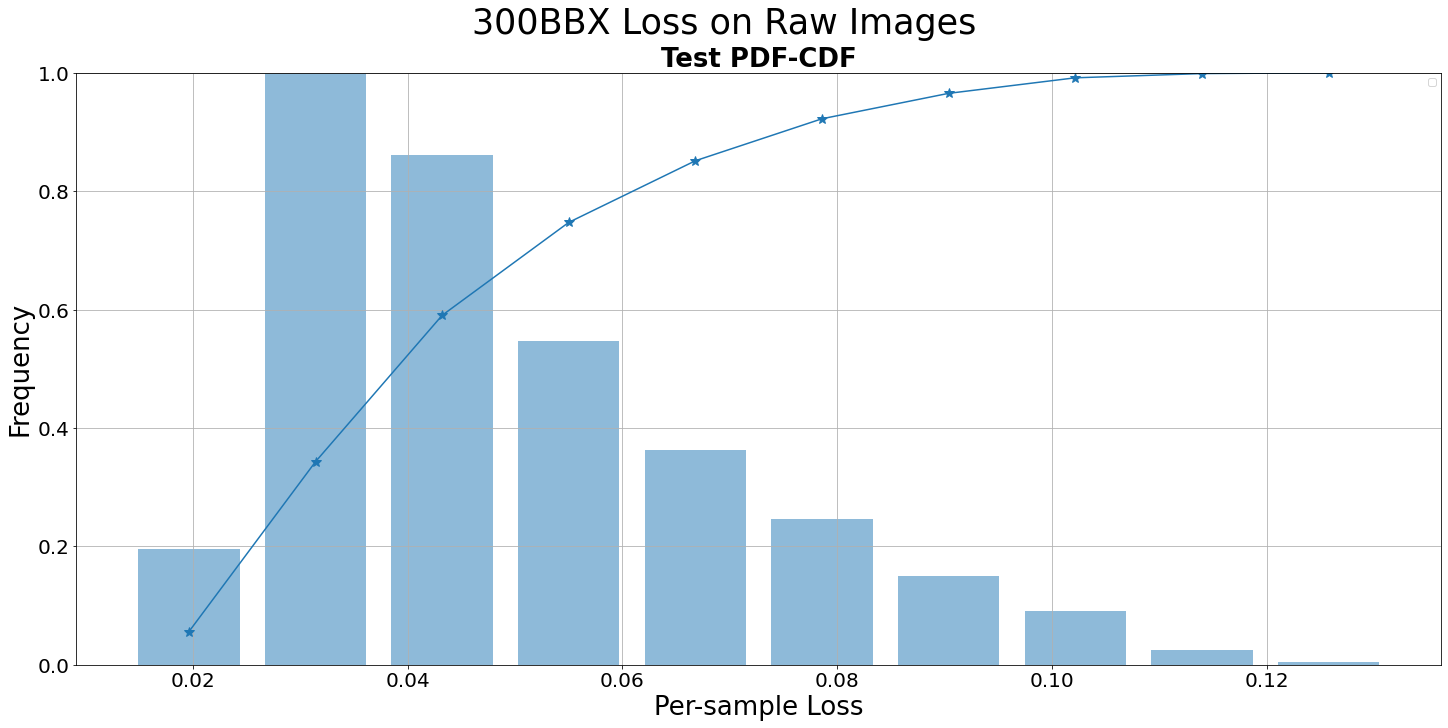

In [11]:
for method in(C30, D30, C100, D100, C300, D300):
    method.calculate_loss()
    fig, filename = method.calculate_cdf()

<Figure size 1440x720 with 0 Axes>

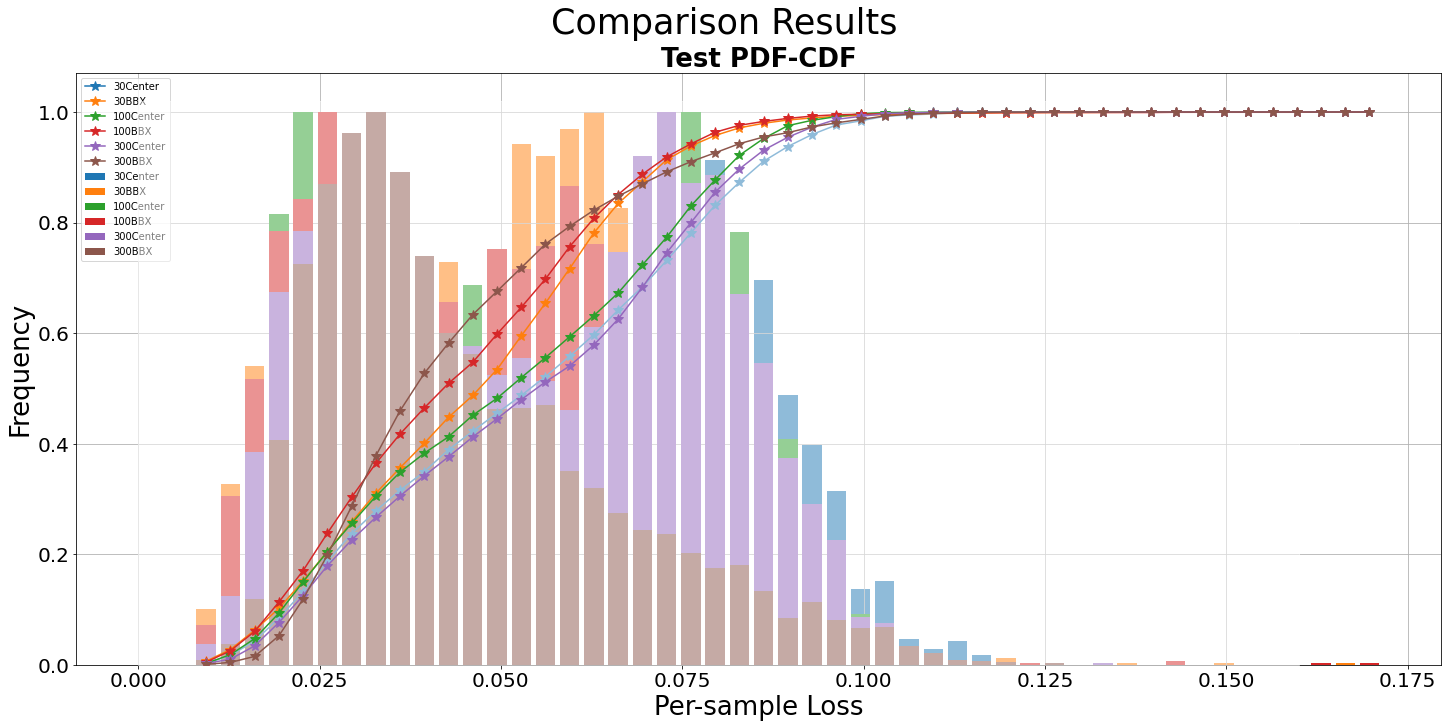

In [12]:
figs.append(CM.gather_plot(C30, D30, C100, D100, C300, D300))

In [13]:
Wi2Vi = CM.ResultCalculator('Wi2Vi', '../saved/240523_Wi2Vi/Wi2Vi_pred.npy', test_gt)
Wi2Vi.resize()

Wi2Vi loading...
Wi2Vi loaded Estimates of (5069, 240, 320) as float32
Wi2Vi resizing...Done!


In [14]:
AE = CM.ResultCalculator('AE', '../saved/240523_AE_2/AE_pred.npy', test_gt)
AE.resize()

AE loading...
AE loaded Estimates of (5069, 128, 128) as float32
AE resizing...Done!


In [19]:
VAE = CM.ResultCalculator('VAE', '../saved/240523_VAE/VAE_pred.npy', test_gt)
VAE.resize()

VAE loading...
VAE loaded Estimates of (5069, 128, 128) as float32
VAE resizing...Done!


In [20]:
TSAE = CM.ResultCalculator('TSAE', '../saved/240523TSAE/Student_pred.npy', test_gt)
TSAE.resize()

TSAE loading...
TSAE loaded Estimates of (5069, 128, 128) as float32
TSAE resizing...Done!


In [21]:
TSVAE = CM.ResultCalculator('TSVAE', '../saved/240523TSVAE/Student_pred.npy', test_gt)
TSVAE.resize()

TSVAE loading...
TSVAE loaded Estimates of (5069, 128, 128) as float32
TSVAE resizing...Done!


Wi2Vi calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
Wi2Vi calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

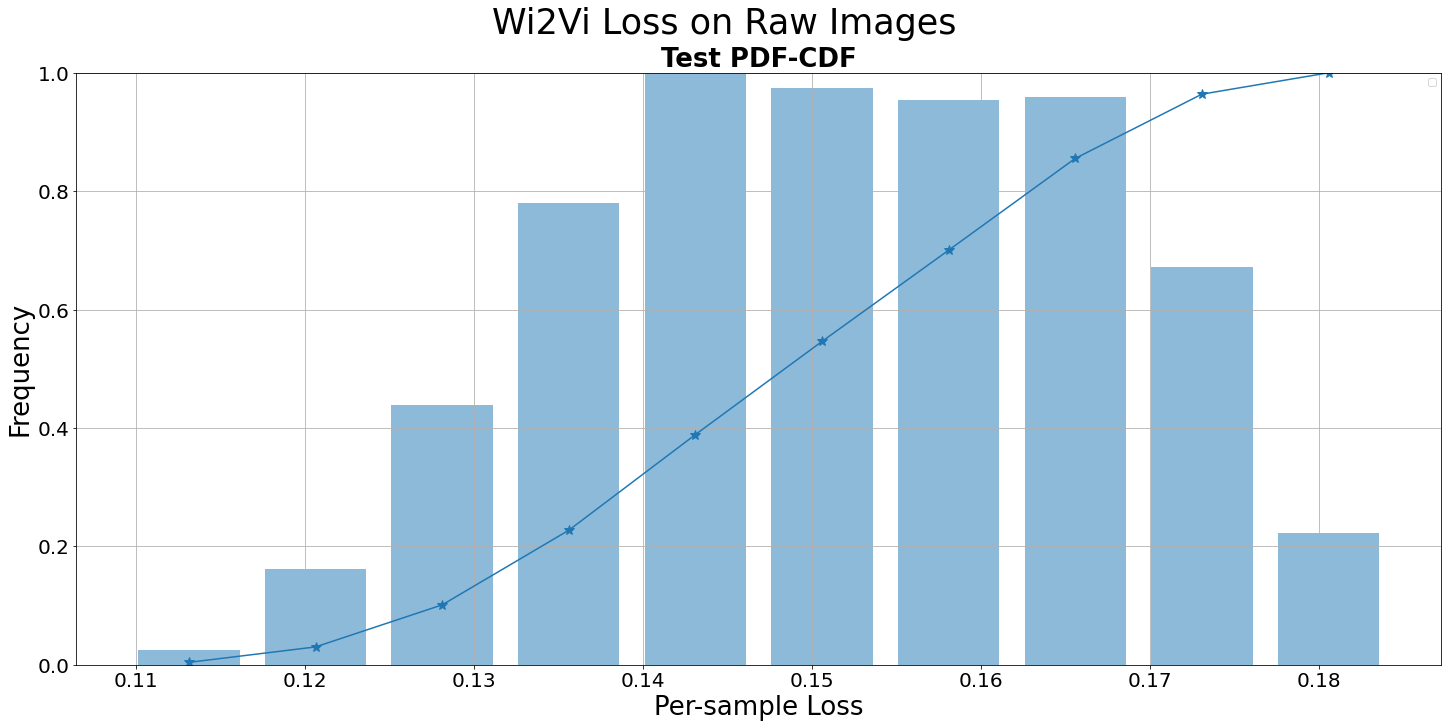

AE calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
AE calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

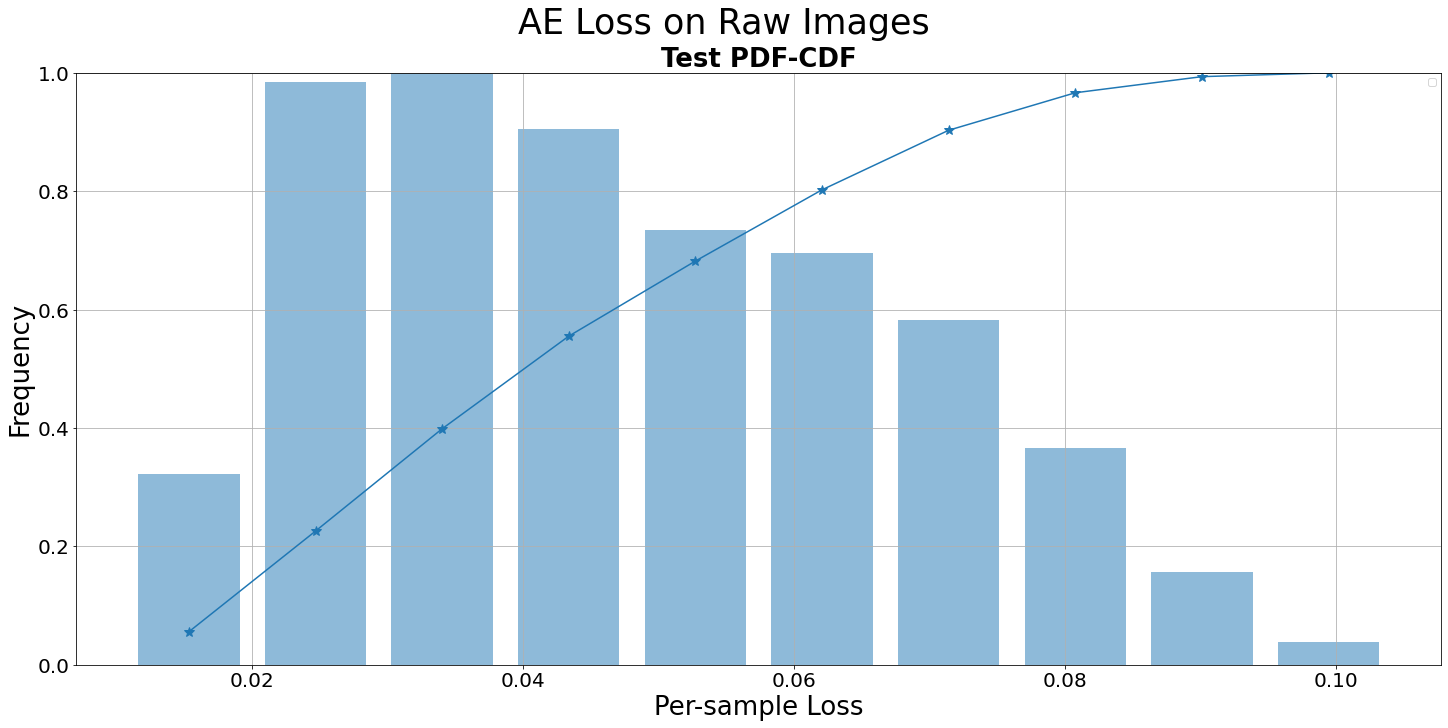

VAE calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
VAE calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

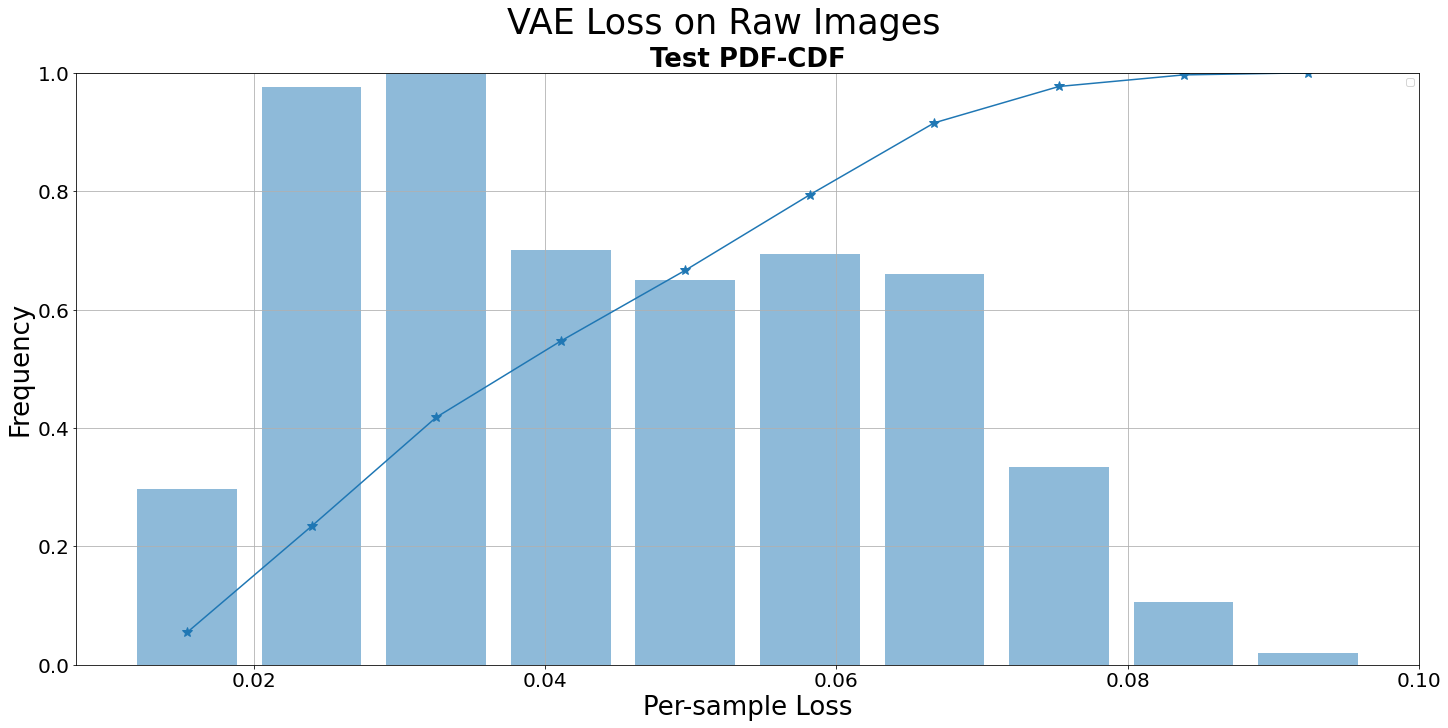

TSAE calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
TSAE calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

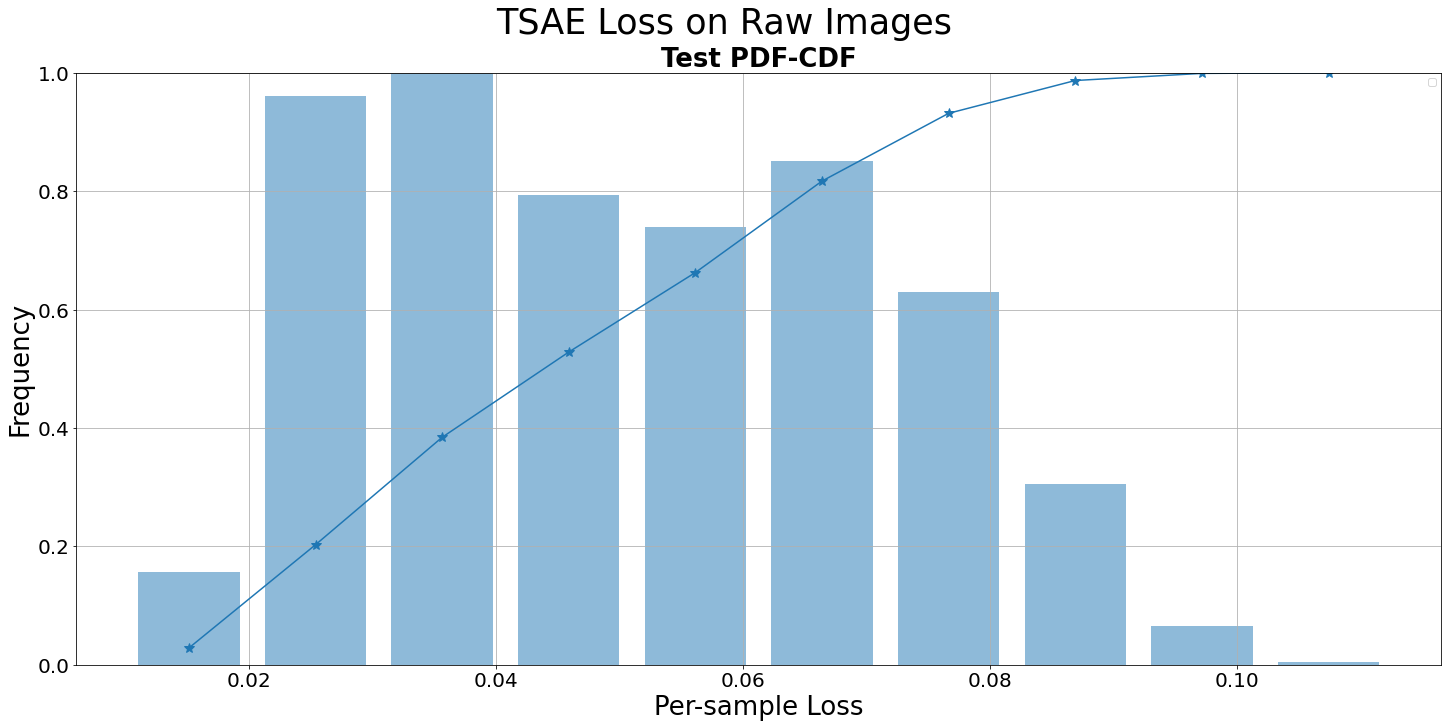

TSVAE calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
TSVAE calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

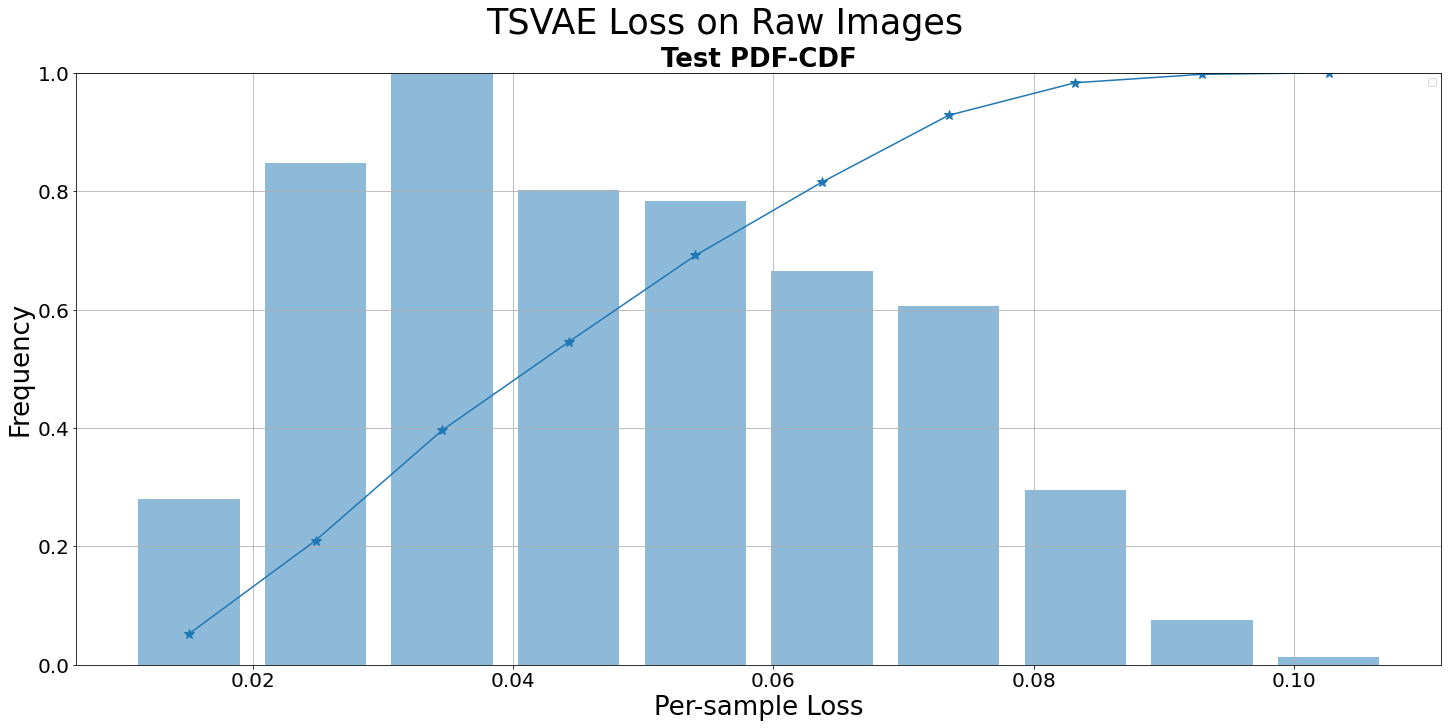

In [22]:
for method in(Wi2Vi, AE, VAE, TSAE, TSVAE):
    method.calculate_loss()
    fig, filename = method.calculate_cdf()

<Figure size 1440x720 with 0 Axes>

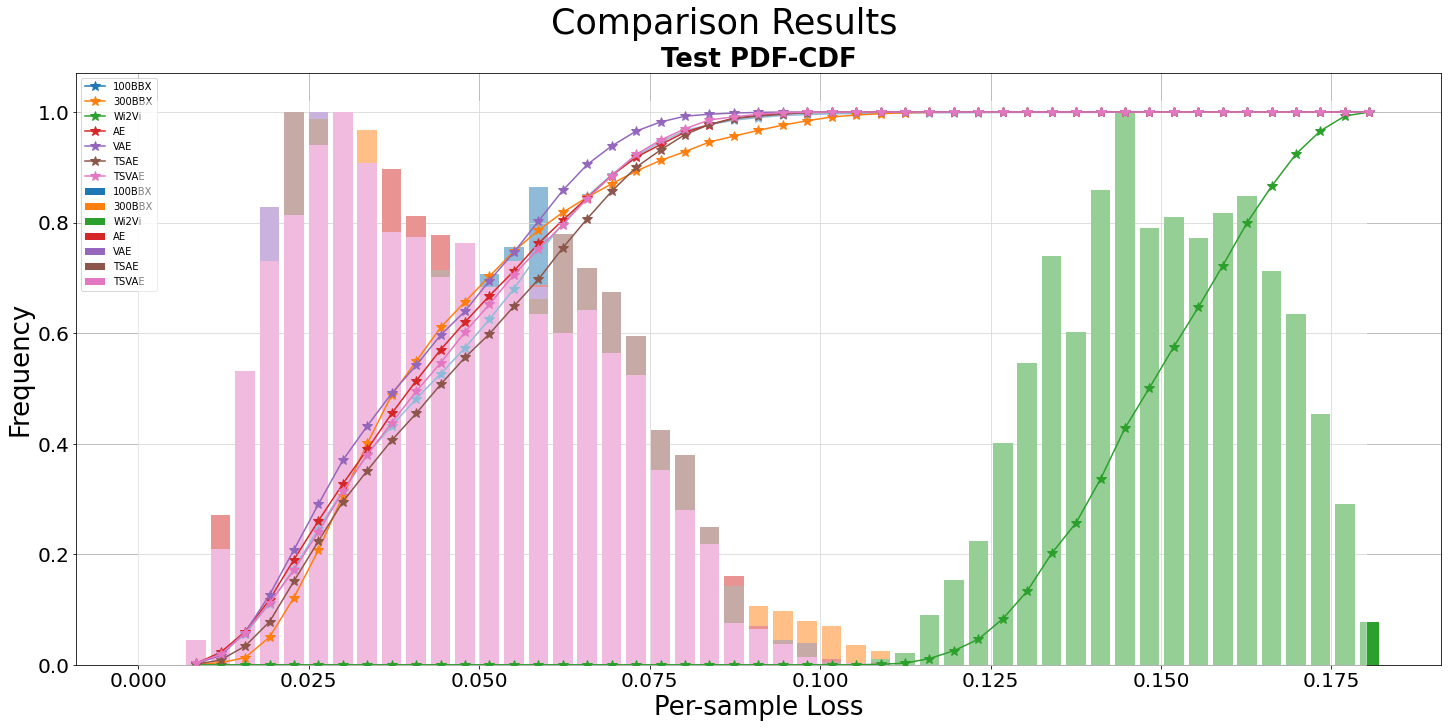

In [23]:
figs.append(CM.gather_plot(D100, D300, Wi2Vi, AE, VAE, TSAE, TSVAE))

Loading from ../dataset/0509/make19_300-finished/


  0%|          | 0/10 [00:00<?, ?it/s]

Profiled by {'T04', 'T03'}
(array([ 936, 3572]),) (array([1]),)
(array([1348]),) (array([0]),)
(array([2155, 4250]),) (array([1]),)
(array([296]),) (array([0]),)
(array([2589, 4683]),) (array([0]),)
(array([4801]),) (array([0]),)
(array([1276, 3919]),) (array([1]),)
(array([803]),) (array([0]),)


TypeError: Invalid shape (0, 128, 226) for image data

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)


<Figure size 1440x720 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:137: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


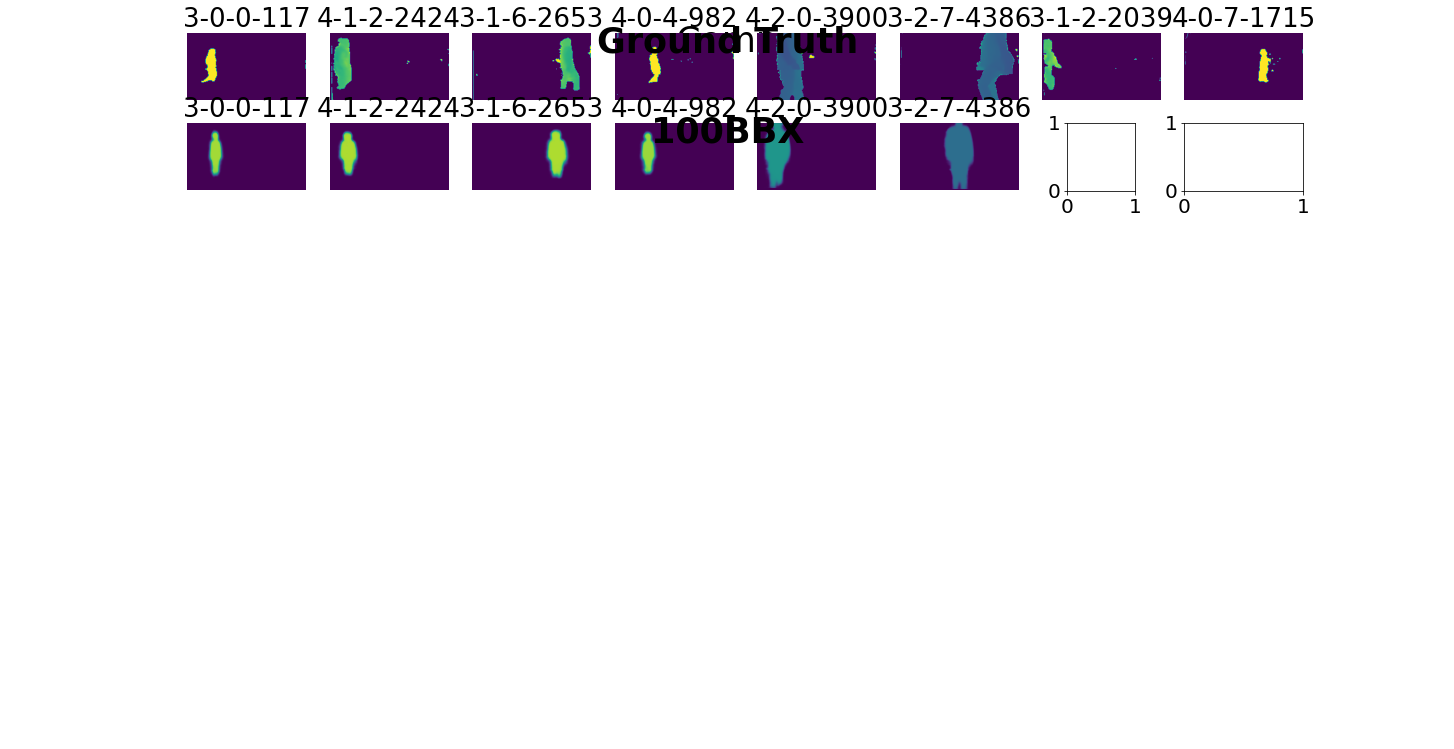

In [25]:
datadir = f'../dataset/0509/make19_300-finished/'
univ_data = DS.ModalityLoader(data_dir=datadir, mmap_mode='r', modalities={'rimg', 'tag'})
univ_gt = data.profiling({'T03', 'T04'})
figs.append(CM.visualization(D100, D300, Wi2Vi, AE, VAE, TSAE, TSVAE, univ_gt=univ_gt, title='Comp'))

In [ ]:
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)
for fig, filename in figs:
    fig.savefig(f"{save_path}{notion}_{filename}")